In [1]:
#Generate data
import numpy as np

n = 100
synthetic_data = np.empty((n*n,3))

x = np.linspace(1,20,n)
y = np.linspace(1,20,n)

for i in range(n):
    for j in range(n):
        #synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],(x[i]-10.0)**2-(y[j]-15)**2])
        synthetic_data[i+j*n-1,:] = np.array([x[i],y[j],0.5*(x[i]-10.0)-2*y[j]])


#Shuffle contents
np.random.shuffle(synthetic_data)

<IPython.core.display.Javascript object>


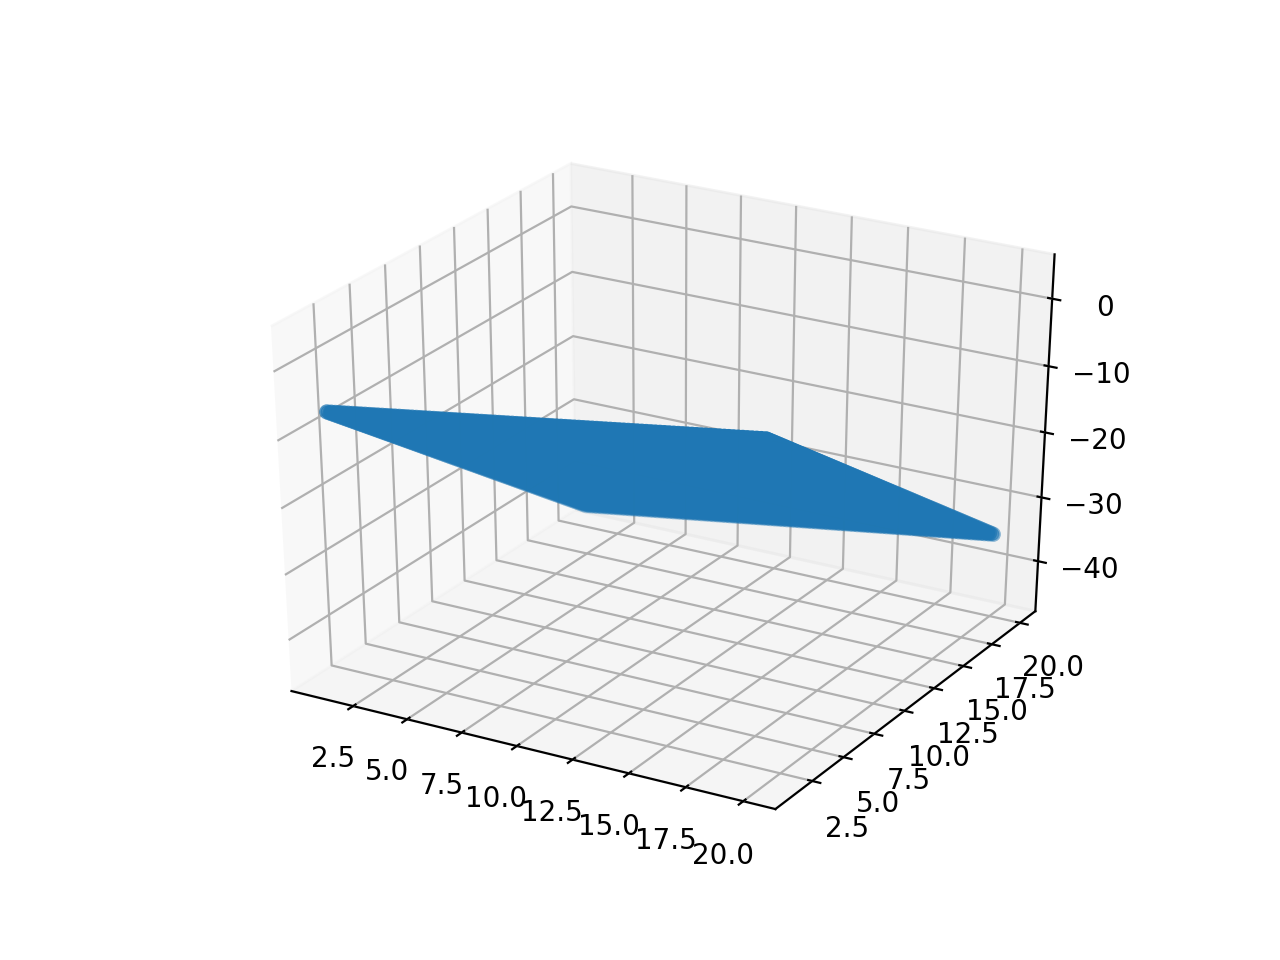

In [2]:
#Graph this data to be sure it is what we want
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:,0], synthetic_data[:,1], synthetic_data[:,2])

In [3]:
#Helper functions
def normalise(x):
    """Convert values to range 0-1"""
    x_h = (x - x.min())*1.0 / (x.max() - x.min())
    
    return x_h, x.min(), x.max()

def un_normalise(x_h, x_min, x_max):
    """Convert values from range 0-1 back to normal"""
    x = (x_max-x_min)*x_h + x_min
    
    return x

In [4]:
#Now let's try with an autoencoder
import tensorflow as tf
#Prepare for training and validation with a 70:30 split
split_size = int(synthetic_data.shape[0]*0.7)

#Normalise values
#x_in, x_min, x_max = normalise(synthetic_data)

x_in = synthetic_data

#Remember that for autoencoders we don't need to have any targets since the values themselves are the targets
#train_x, val_x = x[:split_size], x[split_size:]


# number of neurons in each layer
input_num_units = 3
hidden_num_units = 2
output_num_units = 3

# define placeholders
x = tf.placeholder(tf.float32, [None, input_num_units])
x_h = tf.placeholder(tf.float32, [None, output_num_units])


# define weights and biases of the neural network 

weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units])),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units]))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units])),
    'output': tf.Variable(tf.random_normal([output_num_units]))
}

In [5]:
# hidden = sigmoid(x*w_h+b_h)
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)
#output_layer = hidden*w_o+b_o
output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']
#Define cost
cost = tf.reduce_mean(tf.pow(output_layer - x_h, 2))
cross_entropy = -tf.reduce_sum(output_layer*tf.log(x_h))
#Choose Optimiser
optimiser = tf.train.RMSPropOptimizer(0.005).minimize(cost)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


n_rounds = 1000
batch_size = 10000
loss_vector = np.empty(n_rounds)

0 nan 0.152545


<IPython.core.display.Javascript object>


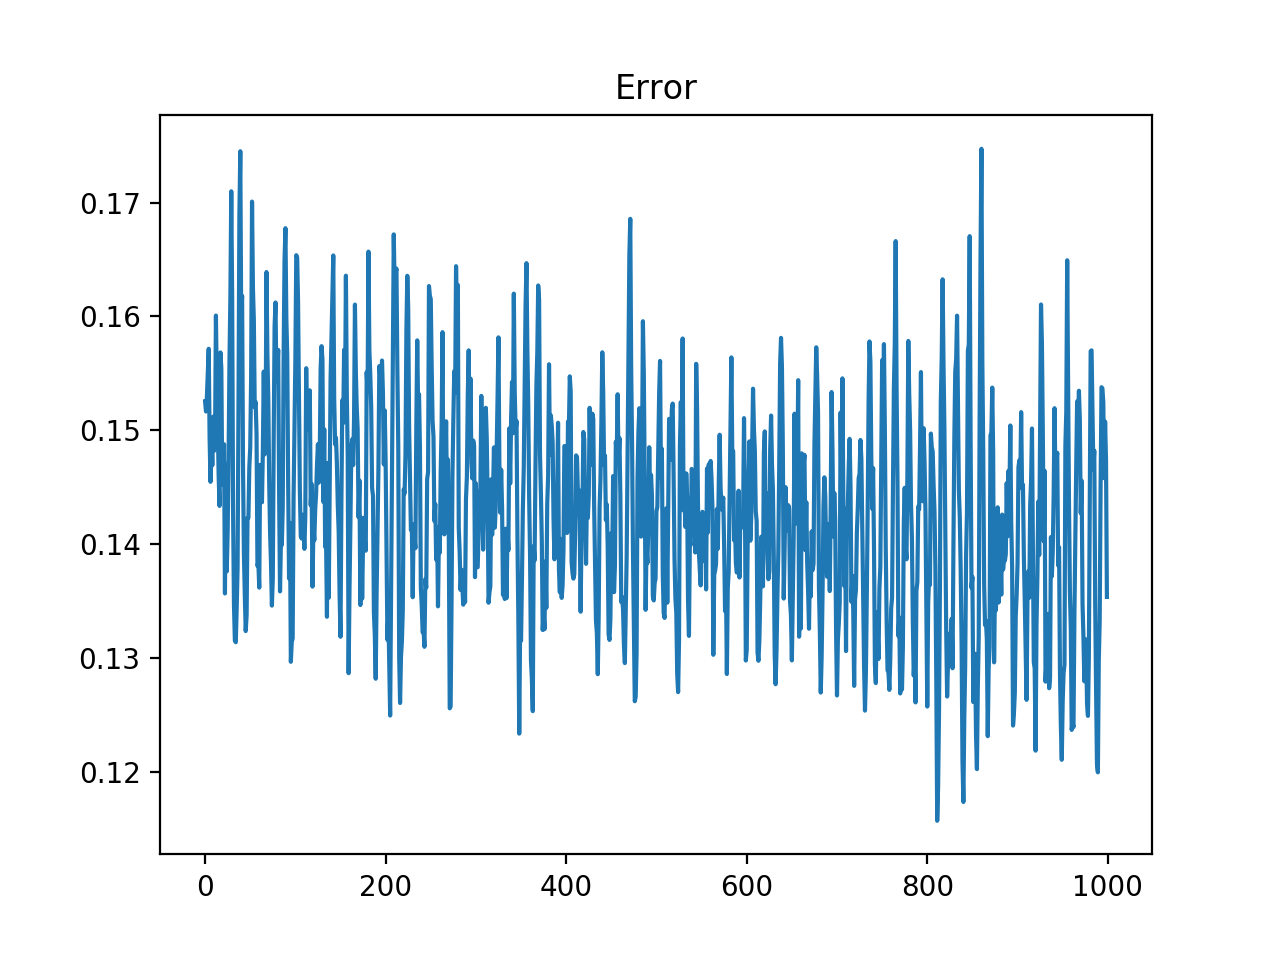

In [8]:
#Training loop

#TODO: add validation since it most likely overfits!

for i in range(n_rounds):
    sample = np.random.randint(n*n, size=batch_size)
    batch_xs = x_in[sample][:]
    batch_ys = x_in[sample][:]
    sess.run(optimiser, feed_dict={x: batch_xs, x_h:batch_ys})
    loss_vector[i] = sess.run(cost, feed_dict={x: batch_xs, x_h:batch_ys})
    if i % 1000 == 0:
        print i, sess.run(cross_entropy, feed_dict={x: batch_xs, x_h:batch_ys}), sess.run(cost, feed_dict={x: batch_xs, x_h:batch_ys})
        
fig = plt.figure()
plt.plot(loss_vector)
plt.title('Error')
plt.show()

In [ ]:
print 'W_h:',sess.run(weights['hidden'])
W_h = sess.run(weights['hidden'])
print 'B_h:',sess.run(biases['hidden'])
B_h = sess.run(biases['hidden'])
print 'W_o:',sess.run(weights['output'])
W_o = sess.run(weights['output'])
print 'B_o:',sess.run(biases['output'])
B_o = sess.run(biases['output'])

In [ ]:
#downscale synthetic data
reconstructed_data = np.empty((n*n,3))
def sigmoid (x): return 1/(1 + np.exp(-x))  
def relu(x): return np.maximum(x, 0)


for i in range(len(x_in)):    
    reconstructed_data[i,:] = np.dot(relu(np.dot(x_in[i,:],W_h)+B_h),W_o)+B_o
    #print np.mean(np.power(reconstructed_data[i,:]-x_in[i,:],2))
#reconstructed_data = un_normalise(reconstructed_data, x_min, x_max)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reconstructed_data[:,0], reconstructed_data[:,1], reconstructed_data[:,2])

In [ ]:
np.savetxt('reconstructed.csv', reconstructed_data, delimiter=",")
np.savetxt('synthetic.csv', synthetic_data, delimiter=",")